# Add Bands 1 and 2 to database

The goal of this notebook is to add estimates of bands 1 and 2 to the database. I want to keep the original database code intact, so doing this in a separate notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, QTable, vstack
import astropy.units as u
from importlib import reload
import wsu_plots
import wsu_db
import large_cubes
import pickle

## reading in the data

In [2]:
# fix up custom units
#gvis = u.def_unit('Gvis',namespace=globals())
#u.add_enabled_units([gvis])

In [3]:
#original versions
#result_c7_mous = QTable.read('data/wsu_datarates_mit_per_mous_cycle7_20231012.ecsv')
#result_c8_mous = QTable.read('data/wsu_datarates_mit_per_mous_cycle8_20231012.ecsv')

# versions removing nbin=2 & npol=4
#result_c7_mous = QTable.read('data/wsu_datarates_mit_per_mous_cycle7_20231012_without_nbin2_npol4.ecsv')
#result_c8_mous = QTable.read('data/wsu_datarates_mit_per_mous_cycle8_20231012_without_nbin2_npol4.ecsv')

# versions enforcing min nbin
result_c7_mous = QTable.read('data/wsu_datarates_mit_per_mous_cycle7_20231212_without_band3_nbin3_npol4.ecsv')
result_c8_mous = QTable.read('data/wsu_datarates_mit_per_mous_cycle8_20231212_without_band3_nbin3_npol4.ecsv')

In [4]:
wsu_all = vstack([result_c7_mous,result_c8_mous])

In [5]:
wsu_all.columns

<TableColumns names=('mous','proposal_id','schedblock_name','array','science_keyword','scientific_category','scientific_category_proposal','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_nchan_agg_finest_early','wsu_nchan_agg_finest_later_2x','wsu_nchan_agg_finest_later_4x','wsu_nchan_agg_stepped_early','wsu_nchan_agg_stepped_later_2x','wsu_nc

In [6]:
wsu_all['weights_all'] = wsu_all['time_tot']/np.sum(wsu_all['time_tot'])

## creating estimated database

In [7]:
reload(wsu_db)
# I need to do 10% total: 5% each for band 1 and lower end of band 2). probably should output the amount of time removed.
(new_db_12m, time_12m) = wsu_db.remove_projects(wsu_all,array='12m',time_frac=0.1)
#  I need to do 6% total: 3% each for band 1 and lower end of Band 2).
(new_db_12m_7m,time_7m) = wsu_db.remove_projects(new_db_12m,array='7m',time_frac=0.06)

---
Total number of MOUSes: 5192
Total number of MOUSes meeting the criteria: 2818
Number of MOUSes removed: 351
New number of MOUSes: 4841


Total time: 5206.931093333333 h
Time to be replaced: 520.6931093333333 h
Time replaced: 522.0443199999996 h
---
---
Total number of MOUSes: 4841
Total number of MOUSes meeting the criteria: 1493
Number of MOUSes removed: 122
New number of MOUSes: 4719


Total time: 3953.507506666667 h
Time to be replaced: 237.2104504 h
Time replaced: 239.1869200000001 h
---


In [9]:
reload(wsu_db)
db_update_band1_12m = wsu_db.add_bands(new_db_12m_7m, array='12m', band=1.0,total_time=time_12m.to('hr')/2.0)
db_update_band2_12m = wsu_db.add_bands(new_db_12m_7m, array='12m', band=2.0,total_time=time_12m.to('hr')/2.0)

In [10]:
reload(wsu_db)
db_update_band1_7m = wsu_db.add_bands(new_db_12m_7m, array='7m', band=1.0,total_time=time_7m.to('hr')/2.0)
db_update_band2_7m = wsu_db.add_bands(new_db_12m_7m, array='7m', band=2.0,total_time=time_7m.to('hr')/2.0)

In [11]:
# combine everything
wsu_all_band1_band2 = vstack([new_db_12m_7m, 
                              db_update_band1_12m, db_update_band2_12m, 
                              db_update_band1_7m, db_update_band2_7m])

In [12]:
#wsu_all_band1_band2.write('data/wsu_datarates_mit_per_mous_band12_20231012.ecsv',overwrite=True)
#wsu_all_band1_band2.write('data/wsu_datarates_mit_per_mous_band12_20231212_without_nbin2_npol4.ecsv',overwrite=True)
wsu_all_band1_band2.write('data/wsu_datarates_mit_per_mous_band12_20231212.ecsv',overwrite=True)

## checking on the individual results

Text(0.5, 0, 'velocity resolution (km/s)')

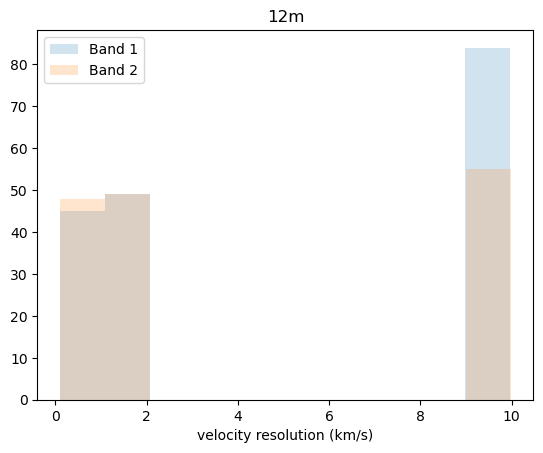

In [13]:
plt.hist(db_update_band1_12m['wsu_velres_stepped2'].value,label='Band 1',alpha=0.2)
plt.hist(db_update_band2_12m['wsu_velres_stepped2'].value,label='Band 2',alpha=0.2)
plt.legend()
plt.title('12m')
plt.xlabel('velocity resolution (km/s)')

Text(0.5, 0, 'nchan per spw')

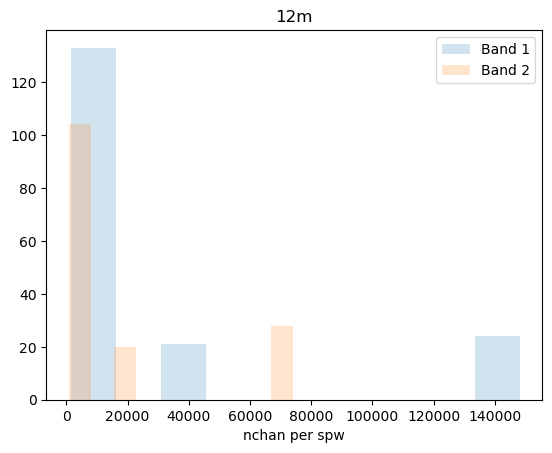

In [14]:
plt.hist(db_update_band1_12m['wsu_nchan_spw_stepped2'].value,label='Band 1',alpha=0.2)
plt.hist(db_update_band2_12m['wsu_nchan_spw_stepped2'].value,label='Band 2',alpha=0.2)
plt.title('12m')
plt.legend()
plt.xlabel('nchan per spw')

In [15]:
np.nanmax(db_update_band1_12m['wsu_nchan_spw_stepped2'])

<Quantity 148148.>

In [16]:
100*14880

1488000

In [17]:
2e9/13.5e3

148148.14814814815

In [18]:
# this gives total BW
14880*13.5

200880.0

In [19]:
# but usable is 200MHz, so have fewer channes.
200.00e6/13.5e3

14814.814814814816

In [20]:
14815*10

148150

The above is within 2 of my max, so good enough.
Based on the above calculations, I think everything is happening properly. I'm just assuming that all the SPWs are contiguous, so the "extra" channels in the 0.88 MHz aren't used.

Text(0.5, 0, 'velocity resolution (km/s)')

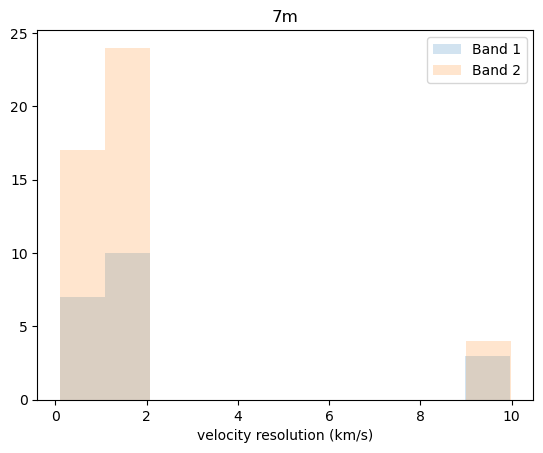

In [21]:
plt.hist(db_update_band1_7m['wsu_velres_stepped2'].value,label='Band 1',alpha=0.2)
plt.hist(db_update_band2_7m['wsu_velres_stepped2'].value,label='Band 2',alpha=0.2)
plt.legend()
plt.title('7m')
plt.xlabel('velocity resolution (km/s)')

Text(0.5, 0, 'nchan per spw')

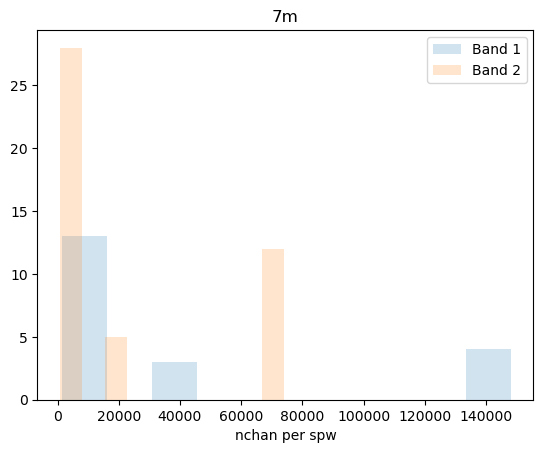

In [22]:
plt.hist(db_update_band1_7m['wsu_nchan_spw_stepped2'].value,label='Band 1',alpha=0.2)
plt.hist(db_update_band2_7m['wsu_nchan_spw_stepped2'].value,label='Band 2',alpha=0.2)
plt.legend()
plt.title('7m')
plt.xlabel('nchan per spw')

In [23]:
db_update_band1_7m.columns

<TableColumns names=('mous','proposal_id','schedblock_name','array','science_keyword','scientific_category','scientific_category_proposal','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_velres','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_nchan_agg_finest_early','wsu_nchan_agg_finest_later_2x','wsu_nchan_agg_finest_later_4x','wsu_nchan_agg_stepped_early','wsu_nchan_agg_stepped_later_2x','wsu_nchan_agg_stepped_later_4x','wsu_nchan_agg_stepped2_early','wsu_nchan_agg_stepped2_later_2x','wsu_nchan_agg_stepped2_later_

Text(0.5, 0, 'required system performance (PFLOP/s)')

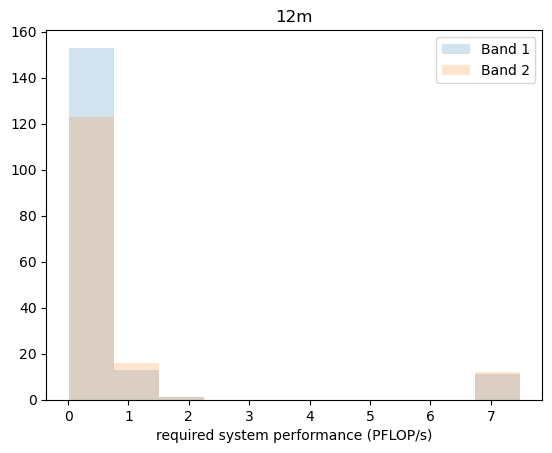

In [24]:
plt.hist(db_update_band1_12m['wsu_sysperf_later_4x_stepped2_typical_aprojonly'].value,label='Band 1',alpha=0.2)
plt.hist(db_update_band2_12m['wsu_sysperf_later_4x_stepped2_typical_aprojonly'].value,label='Band 2',alpha=0.2)
plt.legend()
plt.title('12m')
plt.xlabel('required system performance (PFLOP/s)')

Text(0.5, 0, 'required system performance (PFLOP/s)')

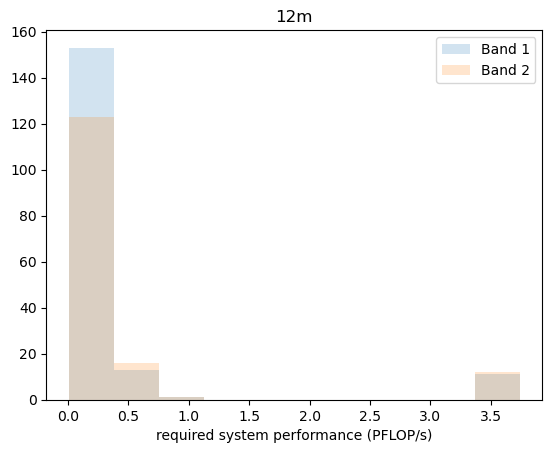

In [25]:
plt.hist(db_update_band1_12m['wsu_sysperf_early_stepped2_typical_aprojonly'].value,label='Band 1',alpha=0.2)
plt.hist(db_update_band2_12m['wsu_sysperf_early_stepped2_typical_aprojonly'].value,label='Band 2',alpha=0.2)
plt.legend()
plt.title('12m')
plt.xlabel('required system performance (PFLOP/s)')

## Checking on the combined results

In [26]:
len(wsu_all_band1_band2)

5137

In [27]:
np.nansum(wsu_all_band1_band2['time_tot']).to('hr')

<Quantity 9217.60368 h>

In [28]:
np.nansum(wsu_all['time_tot']).to('hr')

<Quantity 9160.4386 h>

In [29]:
len(wsu_all_band1_band2)

5137

In [30]:
len(wsu_all)

5192

In [31]:
wsu_all['weights_all'] = wsu_all['time_tot']/np.sum(wsu_all['time_tot'])

In [32]:
wsu_all_band1_band2['weights_all'] = wsu_all_band1_band2['time_tot']/np.sum(wsu_all_band1_band2['time_tot'])

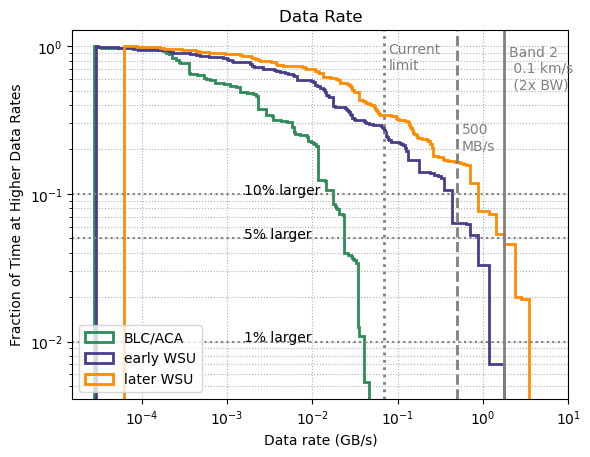

In [33]:
reload(wsu_plots)
wsu_plots.plot_datarate_comparison(wsu_all,
                                   add_band2_specscan=True)

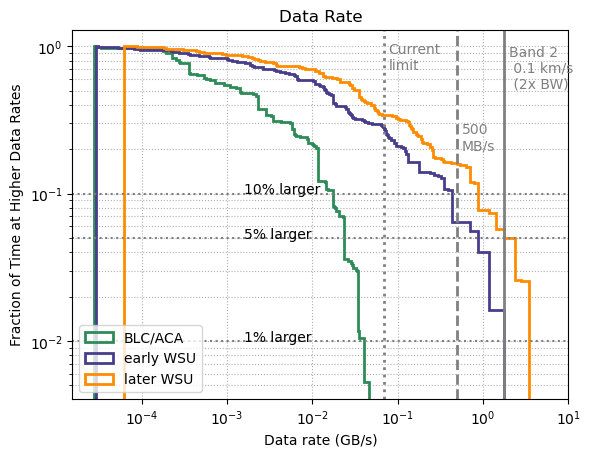

In [34]:
reload(wsu_plots)
wsu_plots.plot_datarate_comparison(wsu_all_band1_band2,
                                   add_band2_specscan=True)

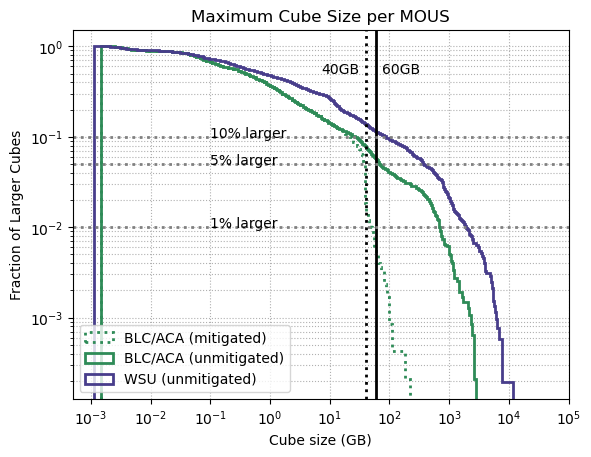

In [35]:
reload(wsu_plots)
wsu_plots.plot_cubesize_comparison(wsu_all,
                                   plot_title='Maximum Cube Size per MOUS')

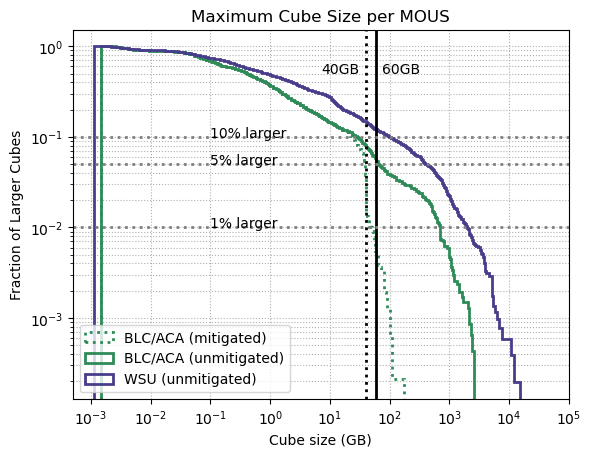

In [36]:
reload(wsu_plots)
wsu_plots.plot_cubesize_comparison(wsu_all_band1_band2,
                                   plot_title='Maximum Cube Size per MOUS')

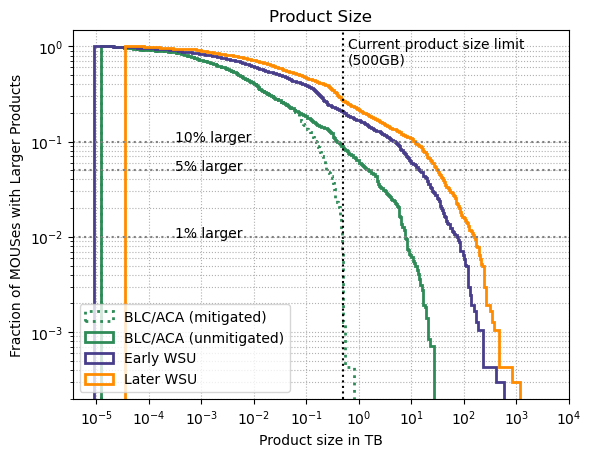

In [37]:
reload(wsu_plots)
wsu_plots.plot_productsize_comparison(wsu_all)

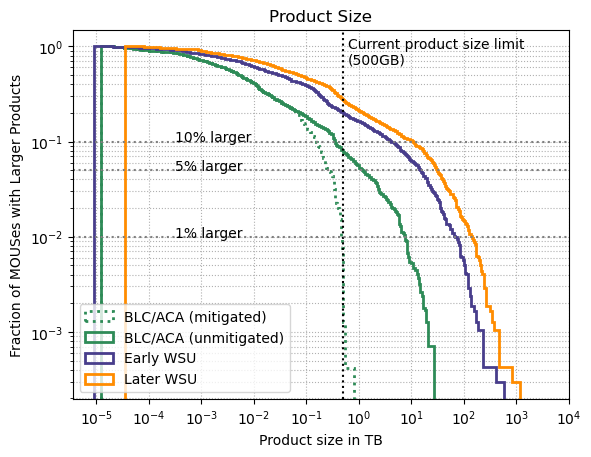

In [38]:
reload(wsu_plots)
wsu_plots.plot_productsize_comparison(wsu_all_band1_band2)

maximum ratio
701.106477037037
median ratio
3.5732498018776875


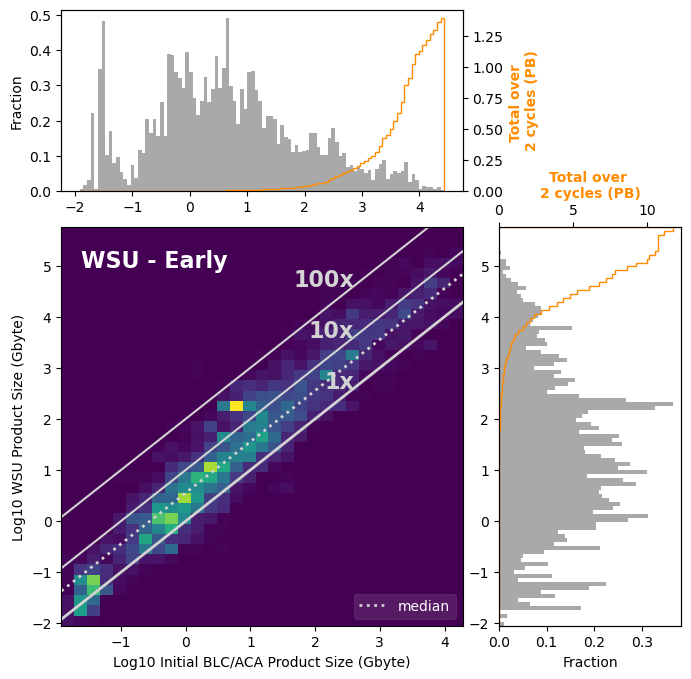

In [39]:
reload(wsu_plots)
wsu_plots.productsize_comparison_hist_plot(wsu_all,stage='early', plot_title='WSU - Early',
                                 blc_mitigated=False, wsu_mitigated=False)

maximum ratio
701.106477037037
median ratio
3.8282418604651163


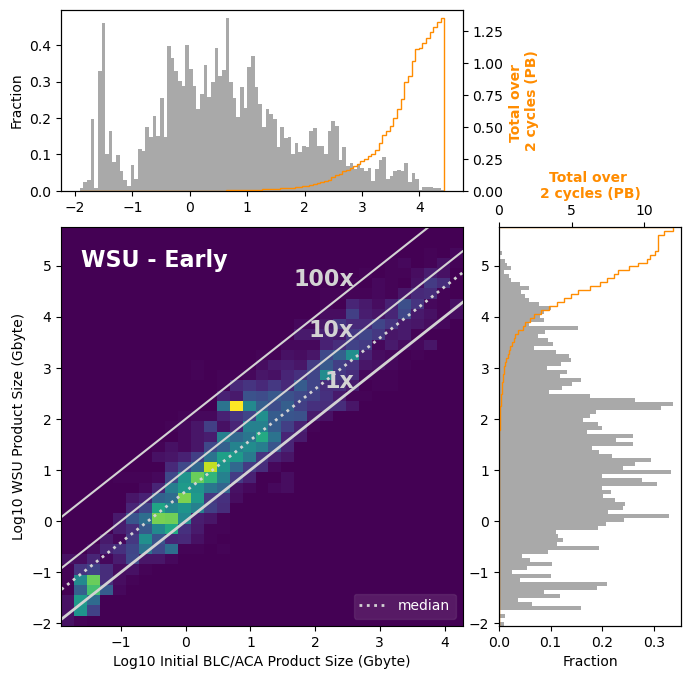

In [40]:
reload(wsu_plots)
wsu_plots.productsize_comparison_hist_plot(wsu_all_band1_band2,stage='early', plot_title='WSU - Early',
                                 blc_mitigated=False, wsu_mitigated=False)

median ratio
3.5732498018776875
max ratio
701.106477037037
log10 (peak)
0.6054485782290385
peak
4.031332114345846


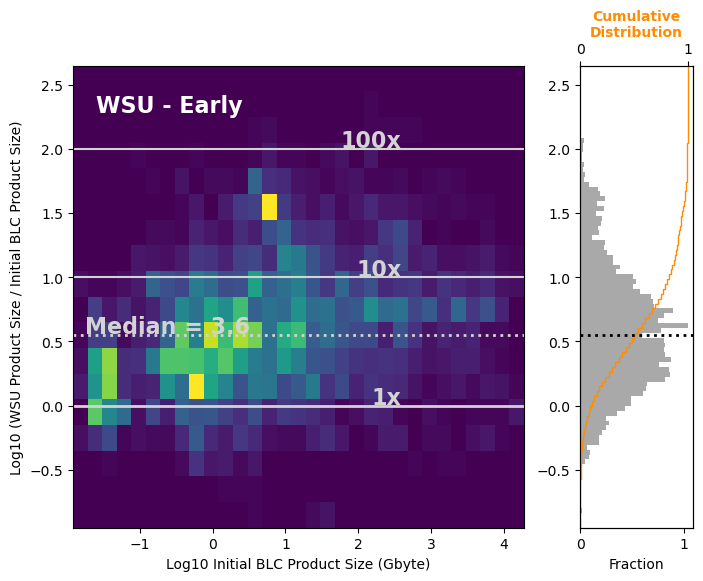

In [41]:
reload(wsu_plots)
wsu_plots.productsize_ratio_hist_plot(wsu_all,stage='early', plot_title='WSU - Early',
                                 blc_mitigated=False, wsu_mitigated=False)

median ratio
3.8282418604651163
max ratio
701.106477037037
log10 (peak)
0.6054485782290385
peak
4.031332114345846


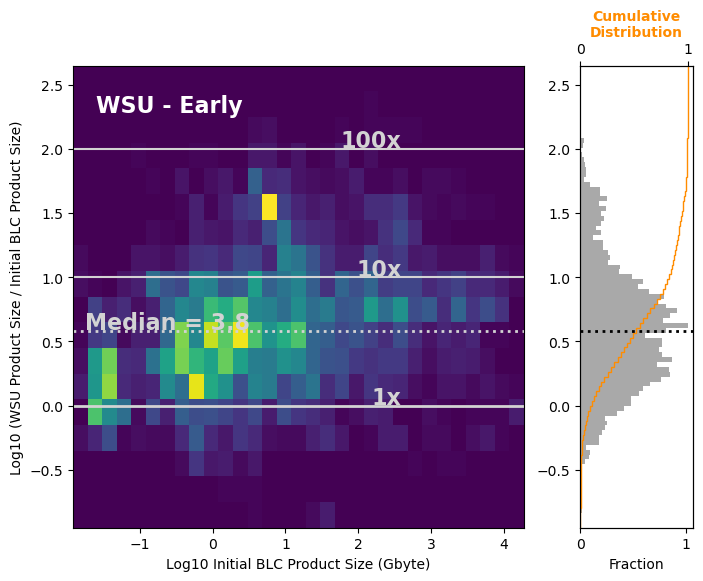

In [42]:
reload(wsu_plots)
wsu_plots.productsize_ratio_hist_plot(wsu_all_band1_band2,stage='early', plot_title='WSU - Early',
                                 blc_mitigated=False, wsu_mitigated=False)

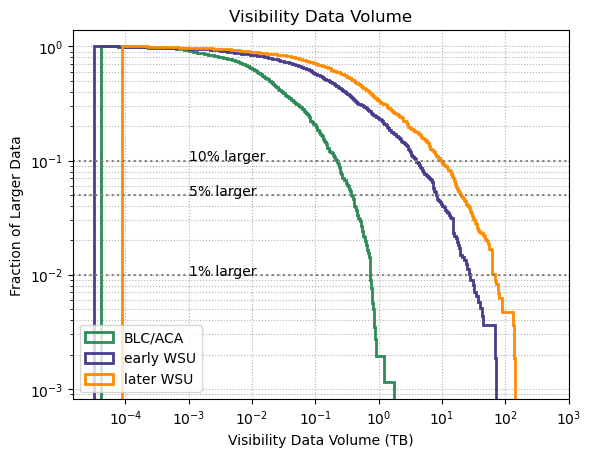

In [43]:
reload(wsu_plots)
wsu_plots.plot_datavol_comparison(wsu_all)

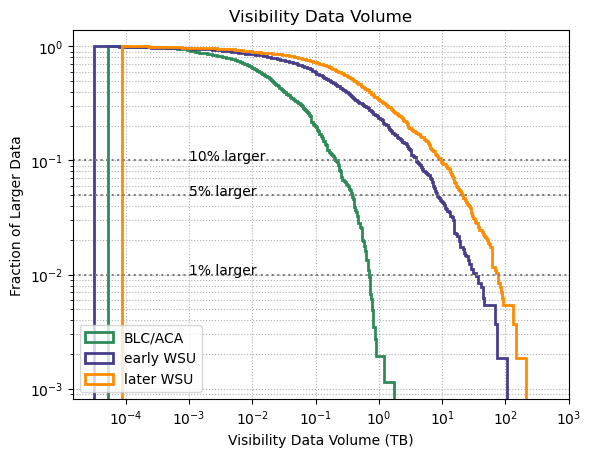

In [44]:
reload(wsu_plots)
wsu_plots.plot_datavol_comparison(wsu_all_band1_band2)

Median Ratio
7.031901041666668
Max Ratio
258.5659906914894


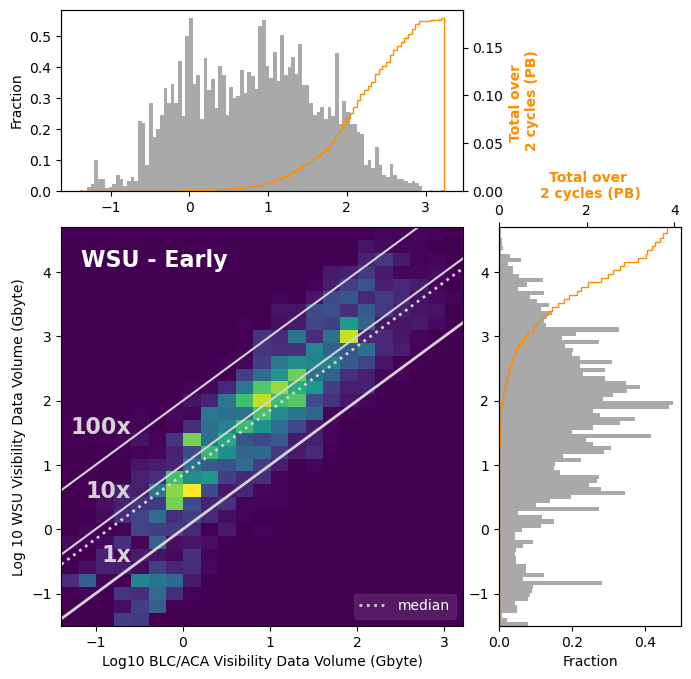

In [45]:
reload(wsu_plots)
wsu_plots.visibility_size_comparison_hist_plot(wsu_all,stage='early',plot_title='WSU - Early')

Median Ratio
7.7898137019230775
Max Ratio
387.85422207446805


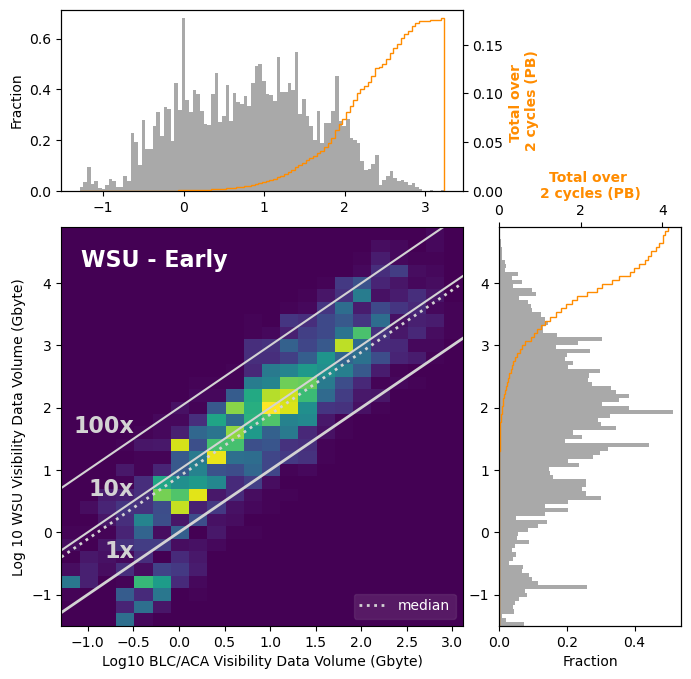

In [46]:
reload(wsu_plots)
wsu_plots.visibility_size_comparison_hist_plot(wsu_all_band1_band2,stage='early',plot_title='WSU - Early')

## Generating sample

In [47]:
## ~24 min to generate 50 samples on laptop.
reload(wsu_db)
#wsu_db.generate_db_realizations(wsu_all, outDir='data/sample_band1_band2',
#                                filename='wsu_datarates_mit_per_mous_band12_20231012',
#                                frac_12m=0.1, frac_7m=0.06, n=50)
#wsu_db.generate_db_realizations(wsu_all, outDir='data/sample_band1_band2_without_nbin2_npol4',
#                                filename='wsu_datarates_mit_per_mous_band12_20231012_without_nbin2_npol4',
#                                frac_12m=0.1, frac_7m=0.06, n=50)
wsu_db.generate_db_realizations(wsu_all, outDir='data/sample_band1_band2_min_nbin',
                                filename='wsu_datarates_mit_per_mous_band12_20231212',
                                frac_12m=0.1, frac_7m=0.06, n=50)

-------------
data/sample_band1_band2_min_nbin/wsu_datarates_mit_per_mous_band12_20231212_000.ecsv
---
Total number of MOUSes: 5192
Total number of MOUSes meeting the criteria: 2818
Number of MOUSes removed: 345
New number of MOUSes: 4847


Total time: 5206.931093333333 h
Time to be replaced: 520.6931093333333 h
Time replaced: 524.2860000000001 h
---
---
Total number of MOUSes: 4847
Total number of MOUSes meeting the criteria: 1493
Number of MOUSes removed: 79
New number of MOUSes: 4768


Total time: 3953.507506666667 h
Time to be replaced: 237.2104504 h
Time replaced: 250.86488000000006 h
---
-------------
data/sample_band1_band2_min_nbin/wsu_datarates_mit_per_mous_band12_20231212_001.ecsv
---
Total number of MOUSes: 5192
Total number of MOUSes meeting the criteria: 2818
Number of MOUSes removed: 354
New number of MOUSes: 4838


Total time: 5206.931093333333 h
Time to be replaced: 520.6931093333333 h
Time replaced: 521.3633600000001 h
---
---
Total number of MOUSes: 4838
Total number 

-------------
data/sample_band1_band2_min_nbin/wsu_datarates_mit_per_mous_band12_20231212_014.ecsv
---
Total number of MOUSes: 5192
Total number of MOUSes meeting the criteria: 2818
Number of MOUSes removed: 374
New number of MOUSes: 4818


Total time: 5206.931093333333 h
Time to be replaced: 520.6931093333333 h
Time replaced: 520.8699999999999 h
---
---
Total number of MOUSes: 4818
Total number of MOUSes meeting the criteria: 1493
Number of MOUSes removed: 142
New number of MOUSes: 4676


Total time: 3953.507506666667 h
Time to be replaced: 237.2104504 h
Time replaced: 237.38400000000013 h
---
-------------
data/sample_band1_band2_min_nbin/wsu_datarates_mit_per_mous_band12_20231212_015.ecsv
---
Total number of MOUSes: 5192
Total number of MOUSes meeting the criteria: 2818
Number of MOUSes removed: 319
New number of MOUSes: 4873


Total time: 5206.931093333333 h
Time to be replaced: 520.6931093333333 h
Time replaced: 521.0805600000001 h
---
---
Total number of MOUSes: 4873
Total number

-------------
data/sample_band1_band2_min_nbin/wsu_datarates_mit_per_mous_band12_20231212_028.ecsv
---
Total number of MOUSes: 5192
Total number of MOUSes meeting the criteria: 2818
Number of MOUSes removed: 326
New number of MOUSes: 4866


Total time: 5206.931093333333 h
Time to be replaced: 520.6931093333333 h
Time replaced: 522.6720799999998 h
---
---
Total number of MOUSes: 4866
Total number of MOUSes meeting the criteria: 1493
Number of MOUSes removed: 81
New number of MOUSes: 4785


Total time: 3953.507506666667 h
Time to be replaced: 237.2104504 h
Time replaced: 238.53367999999995 h
---
-------------
data/sample_band1_band2_min_nbin/wsu_datarates_mit_per_mous_band12_20231212_029.ecsv
---
Total number of MOUSes: 5192
Total number of MOUSes meeting the criteria: 2818
Number of MOUSes removed: 349
New number of MOUSes: 4843


Total time: 5206.931093333333 h
Time to be replaced: 520.6931093333333 h
Time replaced: 522.4228800000003 h
---
---
Total number of MOUSes: 4843
Total number 

-------------
data/sample_band1_band2_min_nbin/wsu_datarates_mit_per_mous_band12_20231212_042.ecsv
---
Total number of MOUSes: 5192
Total number of MOUSes meeting the criteria: 2818
Number of MOUSes removed: 345
New number of MOUSes: 4847


Total time: 5206.931093333333 h
Time to be replaced: 520.6931093333333 h
Time replaced: 522.0868800000006 h
---
---
Total number of MOUSes: 4847
Total number of MOUSes meeting the criteria: 1493
Number of MOUSes removed: 101
New number of MOUSes: 4746


Total time: 3953.507506666667 h
Time to be replaced: 237.2104504 h
Time replaced: 251.30448000000038 h
---
-------------
data/sample_band1_band2_min_nbin/wsu_datarates_mit_per_mous_band12_20231212_043.ecsv
---
Total number of MOUSes: 5192
Total number of MOUSes meeting the criteria: 2818
Number of MOUSes removed: 368
New number of MOUSes: 4824


Total time: 5206.931093333333 h
Time to be replaced: 520.6931093333333 h
Time replaced: 521.0497600000004 h
---
---
Total number of MOUSes: 4824
Total number

## Measuring aggregate sample properties

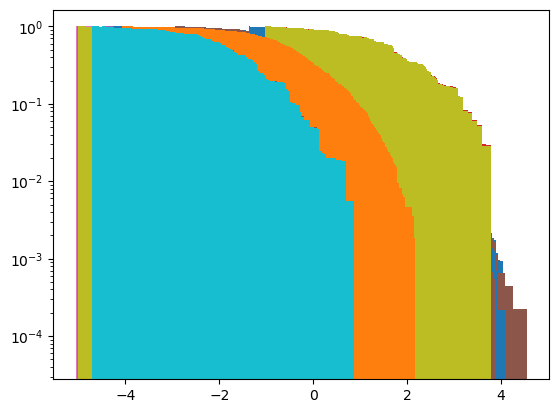

In [48]:
reload(wsu_db)
#myresults = wsu_db.calculate_dist(outDir='data/sample_band1_band2',
#                                  filename='wsu_datarates_mit_per_mous_band12_20231012',
#                                  nbins=500)
reload(wsu_db)
myresults = wsu_db.calculate_dist(outDir='data/sample_band1_band2_min_nbin',
                                  filename='wsu_datarates_mit_per_mous_band12_20231212',
                                  nbins=500)

Checking that plots work for data rates

In [49]:
bin_max=4.5
nbin=100

In [50]:
myresults['hist']['wsu_datarate_early_stepped2_typical'].keys()

dict_keys(['unit', 'bins', 'hist_counts', 'median', 'min', 'max'])

In [51]:
myresults['hist']['wsu_datarate_later_4x_stepped2_typical'].keys()

dict_keys(['unit', 'bins', 'hist_counts', 'median', 'min', 'max'])

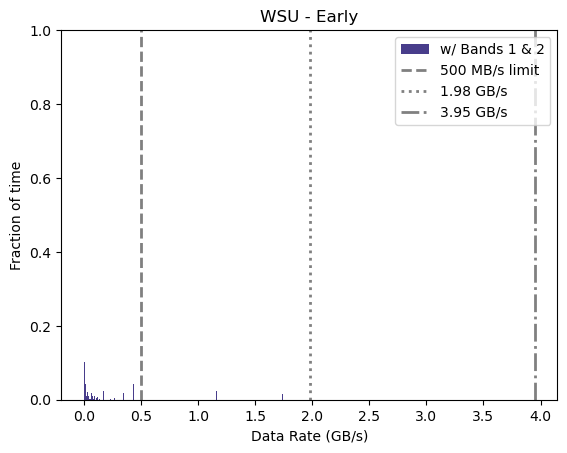

In [52]:
reload(wsu_plots)
wsu_plots.plot_datarate_result_hist(wsu_all,bin_min=0,bin_max=bin_max, nbin=nbin,
                                   data_val= 'wsu_datarate_early_stepped2_typical',log=False,
                                   title='WSU - Early',
                                   add_wavg=False,
                                   limit=0.5, #GB/s = 500MB/s
                                   limit_label='500 MB/s limit',
                                   add_band2_specscan=False,
                                   band1_band2_estimate=myresults['hist'],
                                   add_tech_limits=True)

/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_plots.py:2082: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim((0,1))


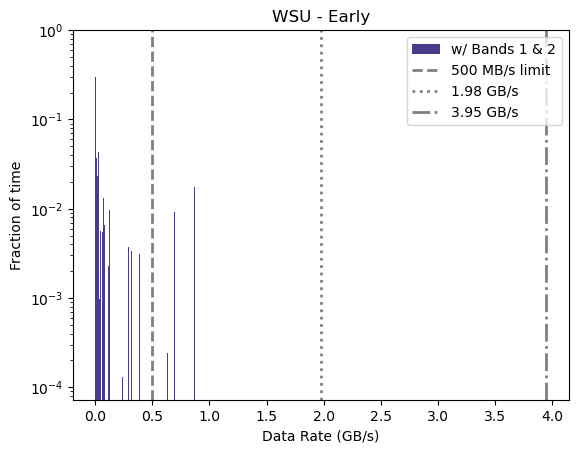

In [53]:
reload(wsu_plots)
wsu_plots.plot_datarate_result_hist(wsu_all,bin_min=0,bin_max=bin_max, nbin=nbin,
                                   data_val= 'wsu_datarate_early_stepped2_typical',
                                   title='WSU - Early',
                                   add_wavg=False,
                                   limit=0.5, # MB/s
                                   limit_label='500 MB/s limit',
                                    add_band2_specscan=False,
                                    add_tech_limits=True,
                                    band1_band2_estimate=myresults['hist_log'])

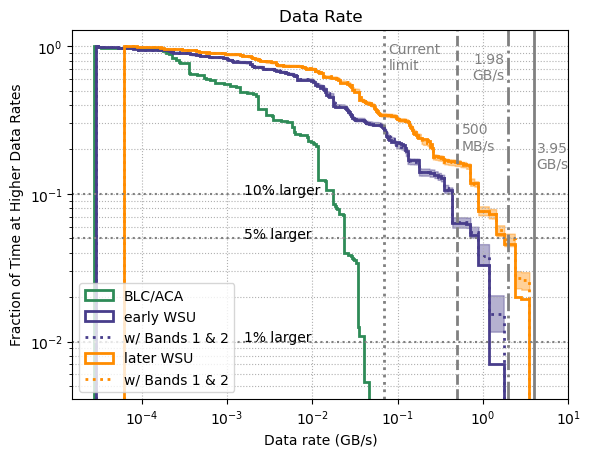

In [54]:
reload(wsu_plots)
wsu_plots.plot_datarate_comparison(wsu_all,
                                   add_band2_specscan=False,
                                   band1_band2_estimate=myresults['hist_cumulative'],
                                   add_tech_limits=True)

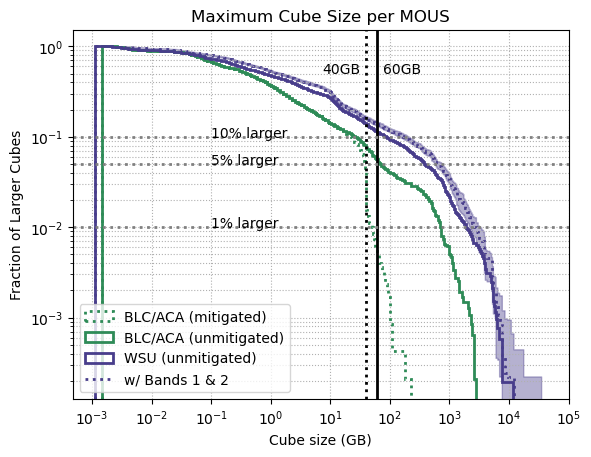

In [56]:
reload(wsu_plots)
wsu_plots.plot_cubesize_comparison(wsu_all,
                                   band1_band2_estimate = myresults['hist_cumulative'],
                                   plot_title='Maximum Cube Size per MOUS')

In [58]:
# save results
import os
pickle.dump(myresults,open(os.path.join('data/sample_band1_band2_min_nbin',
                                        'wsu_datarates_mit_per_mous_band12_20231212'+"_agg.pkl"),'wb'))

In [71]:
reload(wsu_db)
mystats = wsu_db.calc_wsu_stats_allsamples(outDir='data/sample_band1_band2_min_nbin',
                                  filename='wsu_datarates_mit_per_mous_band12_20231212')

In [78]:
# save results
import os
pickle.dump(mystats,open(os.path.join('data/sample_band1_band2_min_nbin',
                                        'wsu_datarates_mit_per_mous_band12_20231212'+"_stats.pkl"),'wb'))

# read in pickle file

In [11]:
import os
with open(os.path.join('data/sample_band1_band2_min_nbin',
                       'wsu_datarates_mit_per_mous_band12_20231212'+"_stats.pkl"),'rb') as f:
    mystats = pickle.load(f)

In [12]:
mystats

{'blc_nspw': {'12m': {'mean_arr': array([4.62266667, 4.61114754, 4.6226601 , 4.59921543, 4.60368058,
          4.59448819, 4.61714097, 4.64042342, 4.62414132, 4.59146141,
          4.60660066, 4.62685582, 4.62351387, 4.60859504, 4.62054161,
          4.60079182, 4.62368074, 4.6128069 , 4.63124793, 4.60513327,
          4.64921641, 4.62816716, 4.61533442, 4.6104918 , 4.60435931,
          4.64474554, 4.63924678, 4.61885922, 4.60572544, 4.62286465,
          4.59407895, 4.6269103 , 4.62334218, 4.62190696, 4.62822607,
          4.60506658, 4.62495916, 4.63000657, 4.62240527, 4.60235448,
          4.62545097, 4.60214355, 4.60130293, 4.62903752, 4.61818779,
          4.61968607, 4.59893934, 4.60700262, 4.62929358, 4.62903752]),
   'wavg_arr': array([4.4498245 , 4.40009276, 4.40563352, 4.38339563, 4.42559496,
          4.37790902, 4.42000552, 4.47586058, 4.432994  , 4.37774178,
          4.44047036, 4.42599774, 4.41879749, 4.36237504, 4.45342461,
          4.43955101, 4.39654993, 4.420619  ,

### Make  stats tables for estimated data properties memo

In [62]:
reload(wsu_db)
wsu_db.make_wsu_stats_table_newstats_datarate(mystats,fileout='tables/wsu_datarate_summary.tex')

In [65]:
reload(wsu_db)
wsu_db.make_wsu_stats_table_newstats_datavol(mystats,fileout='tables/wsu_datavol_summary.tex')

In [66]:
reload(wsu_db)
wsu_db.make_blc_stats_table_newstats_datarate(mystats,fileout='tables/blc_datarate_summary.tex')

In [67]:
reload(wsu_db)
wsu_db.make_blc_stats_table_newstats_datavol(mystats,fileout='tables/blc_datavol_summary.tex')

## make tables for SoC memo

In [68]:
reload(wsu_db)
wsu_db.make_wsu_stats_table_newstats_sysperf(mystats,fileout='tables/wsu_sysperf_summary.tex')

In [13]:
reload(wsu_db)
wsu_db.make_blc_stats_table_newstats_sysperf(mystats,fileout='tables/blc_sysperf_summary.tex')

In [ ]:
wsu_all['wsu_sysperf_early_stepped2_typical_aprojonly']

In [ ]:
mystats['blc_datavol_typical_total']['12m'].keys()

In [ ]:
mystats['wsu_datarate_early_stepped2_typical']['unit']

In [ ]:
mystats.keys()

In [ ]:
mystats.keys()

In [ ]:
mystats['wsu_productsize_early_stepped2']['12m']

In [ ]:
idx = (wsu_all['array'] == '12m')
wsu_all['wsu_productsize_later_4x_stepped2'][idx].to('TB')

In [ ]:
idx = (wsu_all_band1_band2['band'] == 1) & (wsu_all_band1_band2['L80'] > 6.0*u.km)
wsu_all_band1_band2[idx]['mous','band','L80','wsu_nchan_spw_stepped2','wsu_velres_stepped2']

In [ ]:
np.max(wsu_all_band1_band2['L80'])

In [ ]:
test = np.sqrt(2.0*wsu_all_band1_band2['s_resolution'].value/206265.0)*206265 ## units are arcsec here.

In [ ]:
idx = wsu_all_band1_band2['s_fov'].to('arcsec').value > test

In [ ]:
wsu_all_band1_band2[idx]['proposal_id','mous','band','mosaic','L80','s_fov']

So only 11 are greater than the test value. They are all form the infamous Catelyn Casey project where she is doing the blank strips of 30arcmin or so but really narrow. So I think that none of these are true cases where you need w-project.

In [ ]:
wsu_all.columns

In [ ]:
myresults.keys()

In [ ]:
myresults['wsu_nvis_early_stepped2_typical_total'].keys()

In [ ]:
orig, orig_bins, orig_patches = plt.hist(np.log10(wsu_all['wsu_nvis_later_4x_stepped2_typical_total'].value),
                                         cumulative=-1,density=True, log=True,bins=myresults['wsu_nvis_later_4x_stepped2_typical_total']['bins'])

In [ ]:
## magic needed to get last bin filled in: cut off first bin, then do step="pre"
quantity = 'wsu_nvis_later_4x_stepped2_typical_total'
plt.fill_between(myresults[quantity]['bins'][1:],myresults[quantity]['min'],y2=myresults[quantity]['max'], 
                 step="pre",alpha=0.4) 

plt.stairs(myresults[quantity]['median'],myresults[quantity]['bins'], label='median',linewidth=2)

plt.stairs(orig,myresults[quantity]['bins'],label='orig',linewidth=2)
plt.yscale('log')
plt.legend()
#plt.hist(np.log10(wsu_all['wsu_datarate_early_stepped2_typical'].value),cumulative=-1,density=True, 
#         log=True,bins=myresults['bins'],histtype='stepfilled')
plt.xlabel('log10 data rate')
plt.ylabel('number')


The above shows that the initial change in the data rates is a small bump at the middling large data rates, and then at the high end. So my original estimates weren't that bad. Also makes sense because band 1 and 2 are only a small fraction of the data cases by design.

In [ ]:
myresults['wsu_cubesize_stepped2'].keys()

In [70]:
wsu_all.columns

<TableColumns names=('mous','proposal_id','schedblock_name','array','science_keyword','scientific_category','scientific_category_proposal','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_nchan_agg_finest_early','wsu_nchan_agg_finest_later_2x','wsu_nchan_agg_finest_later_4x','wsu_nchan_agg_stepped_early','wsu_nchan_agg_stepped_later_2x','wsu_nc